In [2]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas as pd
from os.path import abspath

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv(abspath('../../../data/MSFT/MSFT-5-Year.csv'), index_col=0, parse_dates=['Date'])

df.columns.name = df.index.name
df.index.name = None

df = df.filter(['Date', 'Open'])
print(df.shape)
df.head()

(1258, 1)


Date,Open
2017-03-01,64.129997
2017-03-02,64.690002
2017-03-03,63.990002
2017-03-06,63.970001
2017-03-07,64.190002


In [5]:
# Split the df into a training set and a test set
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(df, test_size=0.05, shuffle=False)

n_features = 1

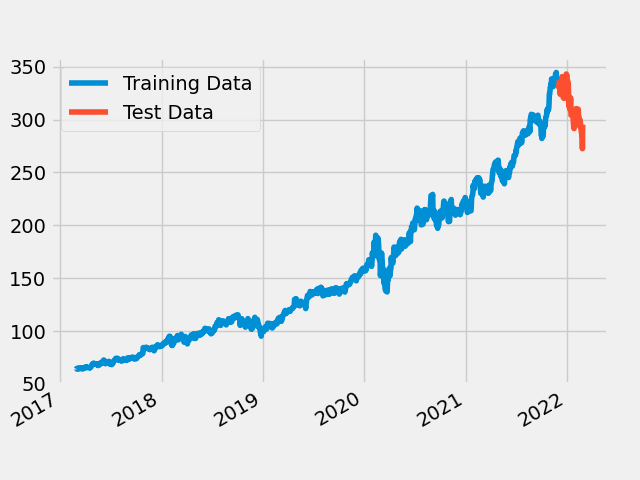

In [6]:
# Plot the training and testing data
train_set.Open.plot(label='Training Data')
test_set.Open.plot(label='Test Data')
plt.legend()

In [7]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler()
train_scaled = transformer.fit_transform(train_set)
test_scaled = transformer.fit_transform(test_set)

In [8]:
from tensorflow import keras

model = keras.models.load_model(abspath('../../../logs/MSFT-5-Year'), compile=False)

Metal device set to: AMD Radeon Pro 560

systemMemory: 16.00 GB
maxCacheSize: 2.00 GB



2022-02-27 19:46:19.998527: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-27 19:46:19.999062: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-27 19:46:19.999261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
inputs = df[len(df)-len(test_set)-60 : ].values
inputs = inputs.reshape(-1,1)
inputs = transformer.transform(inputs)

[[302.86999512]
 [302.20001221]
 [300.98999023]
 [301.01000977]
 [299.77999878]
 [300.82000732]
 [298.42001343]
 [297.54998779]
 [299.55999756]
 [303.26000977]
 [303.76000977]
 [304.17001343]
 [296.32998657]
 [295.69000244]
 [296.73001099]
 [298.8500061 ]
 [298.23001099]
 [296.14001465]
 [289.79998779]
 [285.1000061 ]
 [285.70999146]
 [282.11999512]
 [287.3999939 ]
 [284.04998779]
 [285.77999878]
 [295.17999268]
 [296.22000122]
 [292.92001343]
 [295.33999634]
 [294.91000366]
 [299.20999146]
 [302.33999634]
 [303.57000732]
 [308.3500061 ]
 [309.20999146]
 [307.17001343]
 [310.3999939 ]
 [309.35998535]
 [311.        ]
 [316.        ]
 [324.32998657]
 [324.13000488]
 [331.35998535]
 [330.30999756]
 [333.8999939 ]
 [332.89001465]
 [338.51000977]
 [337.29998779]
 [337.10998535]
 [334.57000732]
 [331.25      ]
 [333.92001343]
 [337.54000854]
 [335.67999268]
 [338.94000244]
 [338.17999268]
 [342.64001465]
 [344.61999512]
 [337.04998779]
 [336.27999878]
 [334.3500061 ]
 [334.94000244]
 [335.32

In [10]:
import numpy as np

x_test = []
for i in range(60,len(inputs)):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

(63, 60, 1)


In [11]:
predicted = model.predict(x_test)
predicted = transformer.inverse_transform(predicted)

2022-02-27 19:46:24.667045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-27 19:46:24.798637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
print(predicted.shape)

# Convert the predicted values to a dataframe
predicted_df = pd.DataFrame(predicted)

# Rename the column to "Open"
predicted_df.columns = ['Open']

# Add a new column called "Date" that has the same index as the other dataframe
predicted_df['Date'] = df[len(df)-len(test_set)-0 : ].index

# Set the 'Date' column as the index
predicted_df = predicted_df.set_index('Date')

predicted_df.head()

(63, 1)


,Open
Date,
2021-11-26,341.217896
2021-11-29,340.159882
2021-11-30,338.907684
2021-12-01,337.895020
2021-12-02,337.191681


<AxesSubplot:xlabel='Date'>

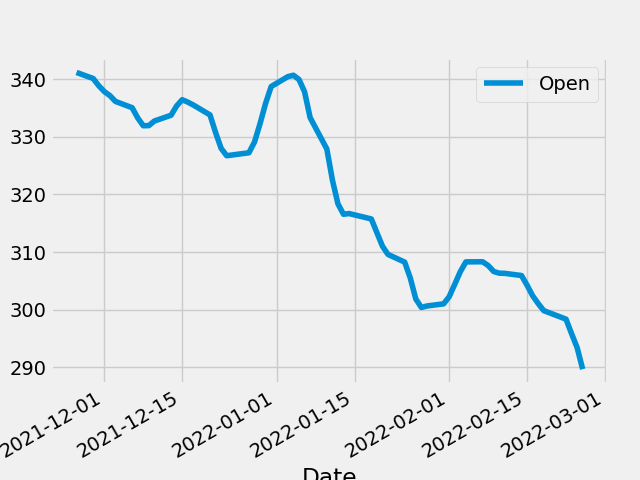

In [13]:
# Plot the predicted values
predicted_df.plot(label='Predicted')

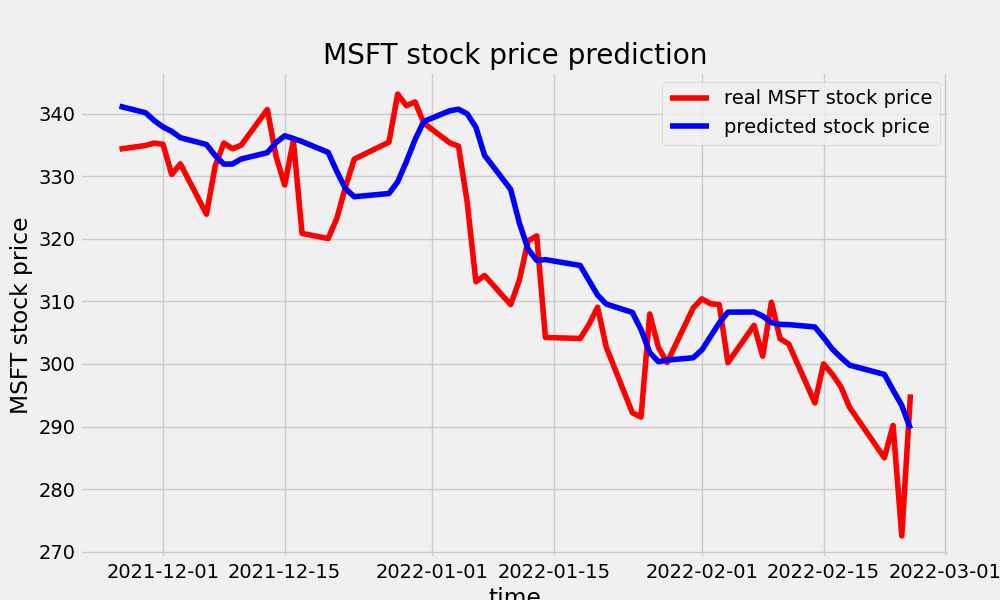

In [14]:
def plot_predictions(test, predicted):
    plt.figure(4, figsize=(10,6))
    plt.plot(test, color="red", label="real MSFT stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("MSFT stock price prediction")
    plt.xlabel("time")
    plt.ylabel("MSFT stock price")
    plt.legend()
    plt.show()

plot_predictions(test_set, predicted_df)

In [15]:
import math
from sklearn.metrics import mean_squared_error

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is: {}".format(rmse))
    return rmse

RMSE = return_rmse(test_set, predicted)

the root mean squared error is: 8.995895335746004


In [42]:
# Predict the model on future data

NUMBER_OF_PREDICTIONS = 10

future_predictions = []

predicted_future = transformer.inverse_transform(x_test[-1])
print(predicted_future)


# for i in range(NUMBER_OF_PREDICTIONS):
#     if i == 0:
#         predicted_future = model.predict(x_test[-1].reshape(1,60,1))
#         predicted_future = transformer.inverse_transform(predicted_future)
#         future_predictions.append(predicted_future.flatten())
#     else:
#         predicted_future = model.predict(predicted_future[-1].reshape(1,60,1))
#         predicted_future = transformer.inverse_transform(predicted_future)
#         future_predictions.append(predicted_future.flatten())

# # Create a dataframe with future_predictions
# future_predictions_df = pd.DataFrame(future_predictions)

# # Add a column to the future_predictions_df with the 10 days after the dataset ends
# future_predictions_df['Date'] = df[len(df)-len(test_set)-0 : ].index + pd.DateOffset(days=10)

[[335.32000732]
 [335.13000488]
 [330.29998779]
 [331.98999023]
 [323.95001221]
 [331.64001465]
 [335.30999756]
 [334.41000366]
 [334.98001099]
 [340.67999268]
 [333.22000122]
 [328.60998535]
 [335.70999146]
 [320.88000488]
 [320.04998779]
 [323.29000854]
 [328.29998779]
 [332.75      ]
 [335.45999146]
 [343.1499939 ]
 [341.29998779]
 [341.91000366]
 [338.51000977]
 [335.3500061 ]
 [334.82998657]
 [325.85998535]
 [313.1499939 ]
 [314.1499939 ]
 [309.48999023]
 [313.38000488]
 [319.67001343]
 [320.47000122]
 [304.25      ]
 [304.07000732]
 [306.29000854]
 [309.07000732]
 [302.69000244]
 [292.20001221]
 [291.51998901]
 [307.98999023]
 [302.66000366]
 [300.23001099]
 [308.95001221]
 [310.41000366]
 [309.63000488]
 [309.48999023]
 [300.20999146]
 [306.17001343]
 [301.25      ]
 [309.86999512]
 [304.04000854]
 [303.19000244]
 [293.76998901]
 [300.01000977]
 [298.36999512]
 [296.35998535]
 [293.04998779]
 [285.        ]
 [290.17999268]
 [272.51000977]]


In [ ]:
plt.figure(20, figsize=(12,8))
plt.plot(future_predictions_df, color="blue", label="predicted stock price")
plt.title("MSFT stock price prediction")
plt.xlabel("time")
plt.ylabel("MSFT stock price")
plt.legend()
plt.show()